## Lab: Support Vector Machine

用到的R库是**`e1071`**。但是也可以使用`LiblinearR`, 这个包可以用大规模的线性问题。由于Maximal Margin Classifer是Supprt Vector Classifer的特列(C=0), 这里就只说Support Vector Classifer和Support Vector Machine了。

### Support Vector Classifer

`e1071`这个库里面有很多统计学习方法。其提供的**`svm()`**函数可以用做Support Vector Classifer, 只需要提供参数**`kernel="linear"`**即可。svm()函数使用一个参数`cost`来控制margin宽度，表示数据点跑到margin内侧(violation)的代价。它跟理论篇里面介绍的C的作用相同。当`cost`很小时(C很大)， margin会很大，反之(C很大)， margin会很小。

下面使用一个二维的例子演示，注意我们故意使得两个类有重合（因为数据是正太分布的）。

In [82]:
library(repr) #改变绘图大小
set.seed(1)
x = matrix(rnorm(20*2), ncol = 2)
y = c(rep(-1,10), rep(1,10))
x[y==1,]=x[y==1,]+1 #让一半的点往右移动1，结果还是会和原来的有一部分重叠，因为x是正态分布生成的。
#plot(x, col=3-y) #绘图，col表示color

接下来把y改成factor(qulitative response)，这样才能用svm()函数做分类，否则就是svm regression machine了（除非使用svm()的type参数控制）。

In [83]:
dat = data.frame(x=x, y=as.factor(y)) #创造一个dataframe，有x和y是column names, x是两列，自动包含了两列
library(e1071)
svmfit = svm(y~., data=dat, kernel = "linear", cost=10, scale=FALSE) #scale=FALSE不要对数据作zero mean 和 unit variance处理
summary(svmfit)


Call:
svm(formula = y ~ ., data = dat, kernel = "linear", cost = 10, scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  10 
      gamma:  0.5 

Number of Support Vectors:  7

 ( 4 3 )


Number of Classes:  2 

Levels: 
 -1 1




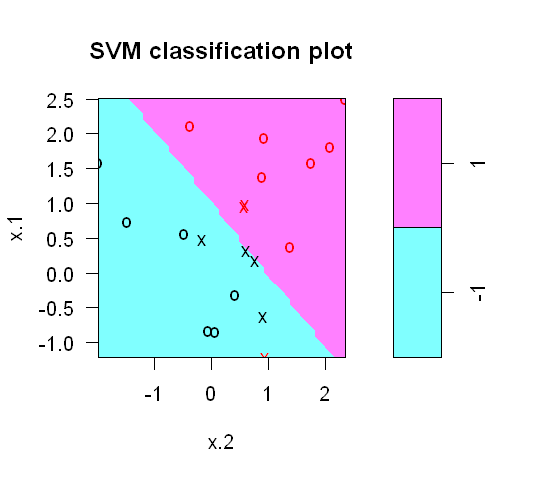

In [84]:
options(repr.plot.width=4.5, repr.plot.height=4) #改变绘图大小
plot(svmfit, dat) #

结果图里面的x表示support vectors， 可以看到有7个x，它们的编号分别是：

In [85]:
svmfit$index

[1]  1  2  5  7 14 16 17

很可惜的是svm()函数并不输出分类边界的参数，也不输出margin的宽度。

`e1071`库还带一个函数`tune()`可以用来给svm的结果做cross validation。
默认是10-fold CV。

In [86]:
set.seed(1)
tune.out = tune(svm, y~., data=dat, kernel="linear", ranges=list(cost=c(0.001, 0.01, 0.1, 1, 10, 100)))
summary(tune.out)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost
  0.1

- best performance: 0.1 

- Detailed performance results:
   cost error dispersion
1 1e-03  0.70  0.4216370
2 1e-02  0.70  0.4216370
3 1e-01  0.10  0.2108185
4 1e+00  0.15  0.2415229
5 1e+01  0.15  0.2415229
6 1e+02  0.15  0.2415229


In [87]:
bestmodel = tune.out$best.model
summary(bestmodel)


Call:
best.tune(method = svm, train.x = y ~ ., data = dat, ranges = list(cost = c(0.001, 
    0.01, 0.1, 1, 10, 100)), kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  0.1 
      gamma:  0.5 

Number of Support Vectors:  16

 ( 8 8 )


Number of Classes:  2 

Levels: 
 -1 1




可以使用`predict()`函数做预测，先来产生test数据

In [88]:
xtest = matrix(rnorm(20*2), ncol=2)
ytest = sample(c(-1,1), 20, rep=TRUE)
xtest[ytest==1,] = xtest[ytest==1,] +1
testdat = data.frame(x=xtest, y=as.factor(ytest))
ypred = predict(bestmodel, testdat)

In [89]:
table(predict=ypred, truth=testdat$y)

       truth
predict -1  1
     -1 11  1
     1   0  8

现在试试如果是maximal margin classifer，在测试数据集上会有哪些问题。首先生成没有重叠（separable）两类点：

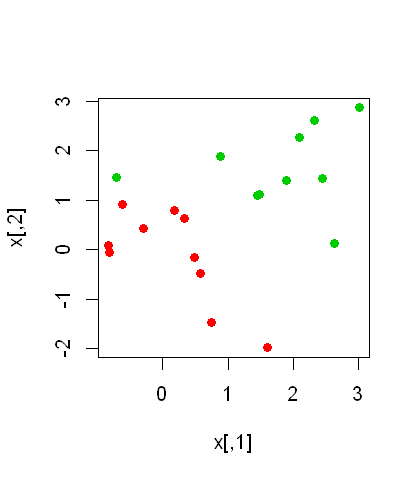

In [90]:
x[y==1,] = x[y==1,] + 0.5 #把x2在往上移动0.5
options(repr.plot.width=3.5, repr.plot.height=4) #改变绘图大小
plot(x, col=(y+5)/2, pch=19)


Call:
svm(formula = y ~ ., data = dat, kernel = "linear", cost = 1e+05)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1e+05 
      gamma:  0.5 

Number of Support Vectors:  3

 ( 1 2 )


Number of Classes:  2 

Levels: 
 -1 1




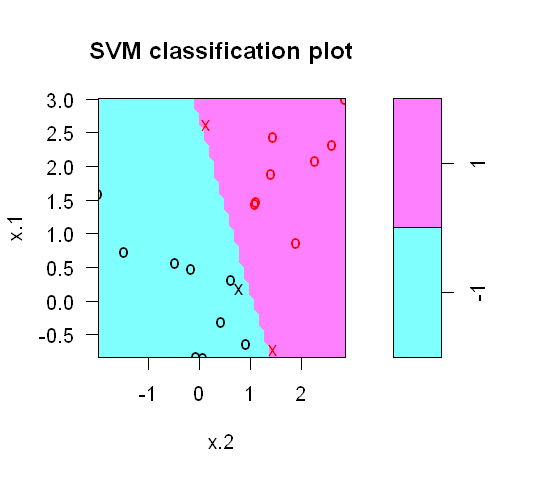

In [91]:
dat = data.frame(x=x, y=as.factor(y))
svmfit = svm(y~., data=dat, kernel = "linear", cost=1e5) # 给一个非常大的cost，保证没有margin violation
summary(svmfit)
options(repr.plot.width=4.5, repr.plot.height=4) #改变绘图大小
plot(svmfit, dat)

In [92]:
ypred = predict(svmfit, testdat)
table(pred=ypred, truth=ytest)

    truth
pred -1  1
  -1 11  2
  1   0  7

试者把cost改成0.1，可以让prediction的误判减小一个。

### Support Vector Machine


仍然使用svm()拟合，但使用非线性的kernel。比如`kernel=polynomial`或者`kernel=radial`， 如果是前者，可以使用degree控制多项式的阶数，
如果是后者，使用gammar参数控制radial base kernel。

In [93]:
set.seed(1)
x=matrix(rnorm(200*2), ncol=2)
options(repr.plot.width=3.5, repr.plot.height=4) #改变绘图大小

让两类数据错开，使得分界为非线性的

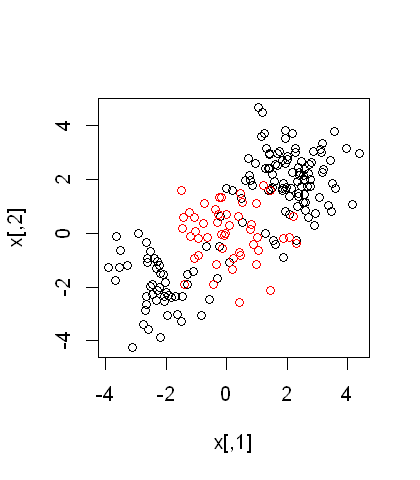

In [94]:
x[1:100, ] = x[1:100, ] + 2
x[101:150, ] = x[101:150, ] - 2
y = c(rep(1, 150), rep(2, 50))
dat = data.frame(x=x, y=as.factor(y))
plot(x, col=y)

In [95]:
train=sample(200,100)
svmfit = svm(y~., data=dat[train,], kernel = "radial", gamma=1, cost=1)

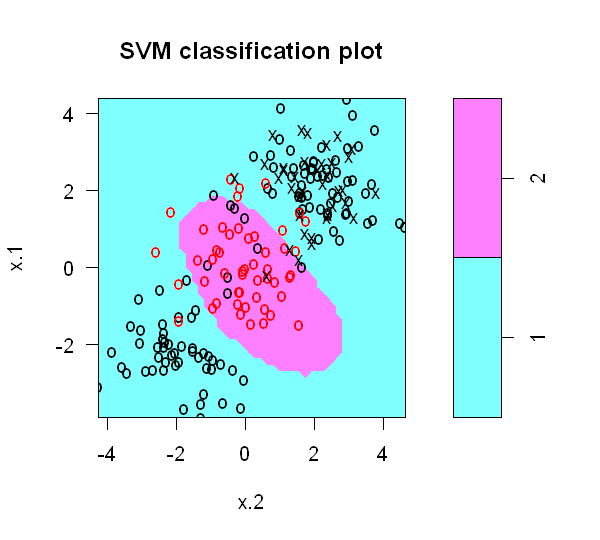

In [96]:
options(repr.plot.width=5, repr.plot.height=4.5) #改变绘图大小
plot(svmfit, dat)

In [97]:
summary(svmfit)


Call:
svm(formula = y ~ ., data = dat[train, ], kernel = "radial", gamma = 1, 
    cost = 1)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  1 

Number of Support Vectors:  37

 ( 17 20 )


Number of Classes:  2 

Levels: 
 1 2




In [98]:
set.seed(1)
tune.out = tune(svm, y~., data=dat[train,], kernel="radial", ranges=list(cost=c(0.1, 1, 10, 100, 1000), 
                                                                 gamma=c(0.5, 1, 2, 3, 4)))
summary(tune.out)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
    1     2

- best performance: 0.12 

- Detailed performance results:
    cost gamma error dispersion
1  1e-01   0.5  0.27 0.11595018
2  1e+00   0.5  0.13 0.08232726
3  1e+01   0.5  0.15 0.07071068
4  1e+02   0.5  0.17 0.08232726
5  1e+03   0.5  0.21 0.09944289
6  1e-01   1.0  0.25 0.13540064
7  1e+00   1.0  0.13 0.08232726
8  1e+01   1.0  0.16 0.06992059
9  1e+02   1.0  0.20 0.09428090
10 1e+03   1.0  0.20 0.08164966
11 1e-01   2.0  0.25 0.12692955
12 1e+00   2.0  0.12 0.09189366
13 1e+01   2.0  0.17 0.09486833
14 1e+02   2.0  0.19 0.09944289
15 1e+03   2.0  0.20 0.09428090
16 1e-01   3.0  0.27 0.11595018
17 1e+00   3.0  0.13 0.09486833
18 1e+01   3.0  0.18 0.10327956
19 1e+02   3.0  0.21 0.08755950
20 1e+03   3.0  0.22 0.10327956
21 1e-01   4.0  0.27 0.11595018
22 1e+00   4.0  0.15 0.10801234
23 1e+01   4.0  0.18 0.11352924
24 1e+02   4.0  0.21 0.08755950
25 1e+03   4.0  0.24 0

In [99]:
table(true=dat[-train, "y"], pred = predict(tune.out$best.model, newdata=dat[-train,]))

    pred
true  1  2
   1 74  3
   2  7 16

### ROC曲线
使用ROCR包

In [100]:
library(ROCR)
rocplot = function(pred, truth, ...) {
    predob = prediction(pred, truth)
    perf = performance(predob, "tpr", "fpr")
    plot(perf, ...)
}

In [111]:
svmfit.opt = svm(y~., data=dat[train,], kernel="radial", gamma=2, cost=1, decision.values=T)
fitted=attributes(predict(svmfit.opt, dat[train,], decision.values=TRUE))$decision.values

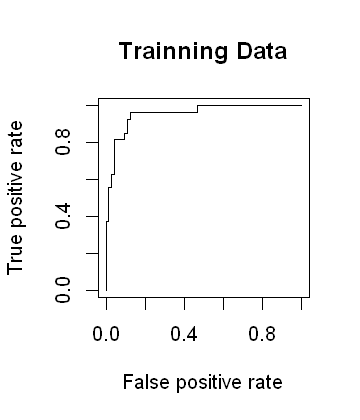

In [112]:
#par(mfrow=c(1,2))
options(repr.plot.width=3, repr.plot.height=3.5) #改变绘图大小
rocplot(fitted, dat[train, "y"], main="Trainning Data")


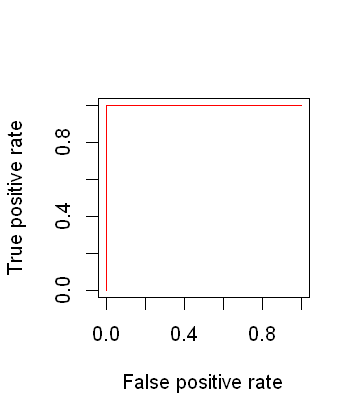

In [118]:
svmfit.opt2 = svm(y~., data=dat[train,], kernel="radial", gamma=50, cost=1, decision.values=T)
fitted2=attributes(predict(svmfit.opt2, dat[train,], decision.values=TRUE))$decision.values
rocplot(fitted2, dat[train, "y"], col="red")

In [131]:
library(ISLR)
names(Khan)

[1] "xtrain" "xtest"  "ytrain" "ytest"

In [149]:
table(Khan$ytrain)


 1  2  3  4 
 8 23 12 20 

In [148]:
table(Khan$ytest)


1 2 3 4 
3 6 6 5 

In [169]:
dat=data.frame(x=Khan$xtrain, y=as.factor(Khan$ytrain))
out=svm(y~., data=dat, kernel = "linear", cost=10)
summary(out)


Call:
svm(formula = y ~ ., data = dat, kernel = "linear", cost = 10)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  10 
      gamma:  0.0004332756 

Number of Support Vectors:  58

 ( 20 20 11 7 )


Number of Classes:  4 

Levels: 
 1 2 3 4




In [170]:
table(out$fitted, dat$y)

   
     1  2  3  4
  1  8  0  0  0
  2  0 23  0  0
  3  0  0 12  0
  4  0  0  0 20

In [171]:
dat.test=data.frame(x=Khan$xtest, y=as.factor(Khan$ytest))

In [172]:
pred.test=predict(out, newdata=dat.test)

In [173]:
table(Khan$ytest, pred.test)

   pred.test
    1 2 3 4
  1 3 0 0 0
  2 0 6 0 0
  3 0 2 4 0
  4 0 0 0 5

In [175]:
tune.out = tune(svm, y~., data=dat, kernel="linear", ranges=list(cost=c(0.1, 1, 10, 100, 1000)))
summary(tune.out)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost
  0.1

- best performance: 0.01428571 

- Detailed performance results:
   cost      error dispersion
1 1e-01 0.01428571  0.0451754
2 1e+00 0.01428571  0.0451754
3 1e+01 0.01428571  0.0451754
4 1e+02 0.01428571  0.0451754
5 1e+03 0.01428571  0.0451754
